<a href="https://colab.research.google.com/github/Dodobaksa/Diver-posture-recognition-project-using-deep-learning/blob/main/_seresnet152_pretraind_false.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install timm

     |████████████████████████████████| 431 kB 5.5 MB/s 


In [ ]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

from torch.utils.data import Dataset,DataLoader
from torchvision import models
from tqdm import tqdm_notebook as tqdm
import math
import timm

In [ ]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.11.0+cu113  Device: cuda


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
transform = transforms.Compose([
        transforms.Resize((128, 128)),    # 이미지 리사이즈
        transforms.ToTensor(),
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
input_dir_path = '/content/gdrive/MyDrive/Colab Notebooks/all-scenarios/'

import os
from PIL import Image
import numpy as np
categories = ['backwards', 'boat', 'carry', 'down', 'end_comm', 'five', 'four', 'here', 'mosaic', 'num_delimiter', 'one', 'photo', 'start_comm', 'three', 'two', 'up']

data = []
label = []

for i, d in enumerate(categories):
  files = os.listdir(input_dir_path +'/'+d) 

  for f in files:
    img = Image.open(input_dir_path + '/' + d + '/'+f, 'r')
    # 이미지를 128, 128로 일괄 리사이즈 한다.
    resize_img = img.resize((128, 128))

    # 이미지를 RGB 컬러로 각각 쪼갠다.

    r, g, b = resize_img.split()
    # 각 쪼갠 이미지를 255로 나눠서 0~1 사이의 값이 나오도록 정규화 한다.
    r_resize_img = np.asarray(np.float32(r) / 255.0)
    b_resize_img = np.asarray(np.float32(g) / 255.0)
    g_resize_img = np.asarray(np.float32(b) / 255.0)

    rgb_resize_img = np.asarray([r_resize_img, b_resize_img, g_resize_img])
    # 이렇게 가공한 이미지를 추가한다.
    data.append(rgb_resize_img)
    # 라벨 
    label.append(i)

pd.DataFrame(data[0][0]).shape




(128, 128)

In [ ]:
import torch
from sklearn import datasets, model_selection
from torch.utils.data import DataLoader, TensorDataset

data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

train_X, test_X, train_Y, test_Y = model_selection.train_test_split(data, label, test_size=0.1)

train_X = torch.from_numpy(train_X).float()
train_Y = torch.from_numpy(train_Y).long()

test_X = torch.from_numpy(test_X).float()
test_Y = torch.from_numpy(test_Y).long()

traina = TensorDataset(train_X, train_Y)
testa = TensorDataset(test_X, test_Y)
train_loader = DataLoader(traina, batch_size=32, shuffle=True)
test_loader = DataLoader(testa, batch_size=32, shuffle=False)

In [ ]:
model = timm.create_model('seresnet152d', pretrained=False, num_classes=16).cuda

In [ ]:
''' 8. CNN 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [ ]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
''' 7. Optimizer, Objective Function 설정하기 '''
model = model()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
''' 10. MLP 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/16849 (0%)]	Train Loss: 2.832412
Train Epoch: 1 [6400/16849 (38%)]	Train Loss: 2.065648
Train Epoch: 1 [12800/16849 (76%)]	Train Loss: 1.218393

[EPOCH: 1], 	Test Loss: 1.0347, 	Test Accuracy: 66.47 % 

Train Epoch: 2 [0/16849 (0%)]	Train Loss: 0.943614
Train Epoch: 2 [6400/16849 (38%)]	Train Loss: 0.481602
Train Epoch: 2 [12800/16849 (76%)]	Train Loss: 0.318364

[EPOCH: 2], 	Test Loss: 0.4897, 	Test Accuracy: 83.72 % 

Train Epoch: 3 [0/16849 (0%)]	Train Loss: 0.267001
Train Epoch: 3 [6400/16849 (38%)]	Train Loss: 0.458967
Train Epoch: 3 [12800/16849 (76%)]	Train Loss: 0.133762

[EPOCH: 3], 	Test Loss: 0.4118, 	Test Accuracy: 86.49 % 

Train Epoch: 4 [0/16849 (0%)]	Train Loss: 0.167208
Train Epoch: 4 [6400/16849 (38%)]	Train Loss: 0.201698
Train Epoch: 4 [12800/16849 (76%)]	Train Loss: 0.132086

[EPOCH: 4], 	Test Loss: 0.2751, 	Test Accuracy: 91.46 % 

Train Epoch: 5 [0/16849 (0%)]	Train Loss: 0.345678
Train Epoch: 5 [6400/16849 (38%)]	Train Loss: 0.143654
Train Epoc

In [ ]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

In [ ]:
def imshow(img):
    img = img  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
def visualize_model(model, num_images=16):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(categories[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

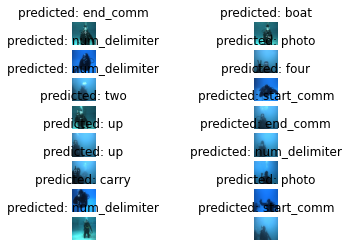

In [ ]:
visualize_model(model)